In [1]:
%pip install xgboost scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

In [3]:
# Downloaded from https://www.smard.de/en/downloadcenter/download-market-data/?downloadAttributes=%7B%22selectedCategory%22:1,%22selectedSubCategory%22:1,%22selectedRegion%22:false,%22selectedFileType%22:%22CSV%22,%22from%22:1546297200000,%22to%22:1701385199999%7D
df = pd.read_csv('data/Actual_generation_201901010000_202311302359_Hour.csv', sep=';')

# Create index from time. TODO: convert to datetime
df['Time'] = df.Date + ' ' + df.Start 
df = df.set_index(pd.to_datetime(df['Time']))
del df['Date']
del df['Start']
del df['End']
del df['Time']

# Convert all cols to floats. Remove commas separating thousands
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

display(df.head())
df.shape

/var/folders/__/6td4hfyx1y191d43ymmp9ykr0000gn/T/ipykernel_30695/1819505191.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = df.set_index(pd.to_datetime(df['Time']))


,Biomass [MWh] Berechnete Auflösungen,Hydropower [MWh] Berechnete Auflösungen,Wind offshore [MWh] Berechnete Auflösungen,Wind onshore [MWh] Berechnete Auflösungen,Photovoltaics [MWh] Berechnete Auflösungen,Other renewable [MWh] Berechnete Auflösungen,Nuclear [MWh] Berechnete Auflösungen,Lignite [MWh] Berechnete Auflösungen,Hard coal [MWh] Berechnete Auflösungen,Fossil gas [MWh] Berechnete Auflösungen,Hydro pumped storage [MWh] Berechnete Auflösungen,Other conventional [MWh] Berechnete Auflösungen
Time,,,,,,,,,,,,
2019-01-01 00:00:00,4815.25,1558.00,3134.00,20391.75,0.0,126.0,9001.50,6335.00,2811.75,3273.25,271.75,1724.25
2019-01-01 01:00:00,4808.75,1553.75,2868.25,22365.50,0.0,126.0,8535.25,5379.50,2404.25,2967.25,21.50,1682.25
2019-01-01 02:00:00,4766.25,1511.00,2460.25,23213.25,0.0,126.0,7954.00,5341.00,2228.50,2720.25,150.75,1625.25
2019-01-01 03:00:00,4750.25,1494.75,2696.50,24493.50,0.0,126.0,7221.75,5270.75,2356.75,2653.25,0.00,1615.25
2019-01-01 04:00:00,4755.50,1458.25,2578.00,26399.00,0.0,125.0,7120.00,5178.75,2308.50,2706.00,3.50,1621.50


(42475, 12)

In [4]:
df.plot.area(figsize=(10,4))

<Axes: xlabel='Time'>

In [ ]:
value_cols = df.columns

delta_hours = 7 * 24

# Create lag features by shifting your target variable (energy mix) backward in time. These lag features represent past values of the energy mix and can be useful for the model. 
# For example, you can create lag features for the past 1 hour, 3 hours, 6 hours, 12 hours, or 24 hours.
for t in [1, 3, 6, 12, 24, 48, 72, 168]:
    for col in value_cols:
        df[f'{col}_Lag_{t}h'] = df[col].shift(t + delta_hours)

# Calculate rolling statistics, such as moving averages and rolling standard deviations, to capture trends and seasonality in the data.
for col in value_cols:
    for t in [24, 48, 72, 168]:
        df[f'{col}_Mean_{t}h'] = df[col].shift(delta_hours).rolling(window=t).mean()
        df[f'{col}_Std_{t}h'] = df[col].shift(delta_hours).rolling(window=t).std()

# Extract time-based features from the datetime index, such as day of the week, month, year, and hour of the day.
df['Day_of_Week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Hour_of_Day'] = df.index.hour

# TODO: Temperature, holidays, inteaction features (e.g. temperature * hour of day)

/var/folders/__/6td4hfyx1y191d43ymmp9ykr0000gn/T/ipykernel_30473/2522576475.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_Lag_{t}h'] = df[col].shift(t + delta_hours)
/var/folders/__/6td4hfyx1y191d43ymmp9ykr0000gn/T/ipykernel_30473/2522576475.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_Lag_{t}h'] = df[col].shift(t + delta_hours)
/var/folders/__/6td4hfyx1y191d43ymmp9ykr0000gn/T/ipykernel_30473/2522576475.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

In [ ]:
# Split into train, validation and test sets

test_start_date = '2023-05-01'
train_val_split = 0.8

train_val_df = df[df.index < test_start_date]
test_df = df[df.index >= test_start_date]

val_start_index = int(train_val_df.shape[0] * train_val_split)
train_df = train_val_df.iloc[:val_start_index]
val_df = train_val_df.iloc[val_start_index:]

In [ ]:
X_train = train_df.drop(value_cols, axis=1)
y_train = train_df[value_cols]
X_validation = val_df.drop(value_cols, axis=1)
y_validation = val_df[value_cols]

# Convert the data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train.values, label=y_train)
dvalidation = xgb.DMatrix(X_validation.values, label=y_validation)

# Define XGBoost hyperparameters (you may need to tune these)
params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 5,                   # Maximum tree depth
    'n_estimators': 100,              # Number of boosting rounds (trees)
    'learning_rate': 0.1,            # Step size shrinkage
}

# Train the XGBoost model
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=params['n_estimators'], 
    evals=[(dtrain, "train"), 
           (dvalidation, "validation")])

# Make predictions on the validation set
y_pred = model.predict(dvalidation)


/Users/jvh/Desktop/Porsche Challenge/hpi-porsche-challenge/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:40:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:5164.64117	validation-rmse:5089.18678
[1]	train-rmse:4733.48961	validation-rmse:4790.71324
[2]	train-rmse:4348.67311	validation-rmse:4567.95157
[3]	train-rmse:4006.68509	validation-rmse:4340.71303
[4]	train-rmse:3694.41280	validation-rmse:4180.25664
[5]	train-rmse:3416.54443	validation-rmse:4070.98676
[6]	train-rmse:3161.81252	validation-rmse:3948.94535
[7]	train-rmse:2937.24603	validation-rmse:3897.58888
[8]	train-rmse:2740.99302	validation-rmse:3851.08855
[9]	train-rmse:2566.33674	validation-rmse:3828.36158
[10]	train-rmse:2405.53381	validation-rmse:3804.09361
[11]	train-rmse:2264.33062	validation-rmse:3770.60703
[12]	train-rmse:2118.97269	validation-rmse:3747.88384
[13]	train-rmse:2002.41310	validation-rmse:3738.31756
[14]	train-rmse:1897.24842	validation-rmse:3724.92921
[15]	train-rmse:1807.35710	validation-rmse:3724.86958
[16]	train-rmse:1711.11345	validation-rmse:3700.46271
[17]	train-rmse:1631.12979	validation-rmse:3712.11211
[18]	train-rmse:1555.55603	validation-

In [ ]:
# Calculate the root mean squared error (RMSE) on the validation set
rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

print()

# Per-category RMSE
rmse_per_category = np.sqrt(mean_squared_error(y_validation, y_pred, multioutput='raw_values'))
rmse_per_category = pd.Series(rmse_per_category, index=y_validation.columns)
print(f"Validation RMSE per category: {rmse_per_category}")

Validation RMSE: 3816.5272

Validation RMSE per category: Biomass [MWh] Calculated resolutions                   195.313236
Hydropower [MWh] Calculated resolutions                219.179999
Wind offshore [MWh] Calculated resolutions            1870.630977
Wind onshore [MWh] Calculated resolutions            10193.571494
Photovoltaics [MWh] Calculated resolutions            6163.656160
Other renewable [MWh] Calculated resolutions            19.914216
Nuclear [MWh] Calculated resolutions                  1440.338731
Lignite [MWh] Calculated resolutions                  3042.612071
Hard coal [MWh] Calculated resolutions                3614.741487
Fossil gas [MWh] Calculated resolutions               1853.322358
Hydro pumped storage [MWh] Calculated resolutions     1207.413865
Other conventional [MWh] Calculated resolutions        118.682244
dtype: float64


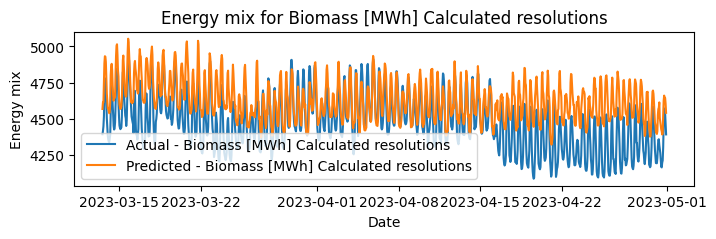

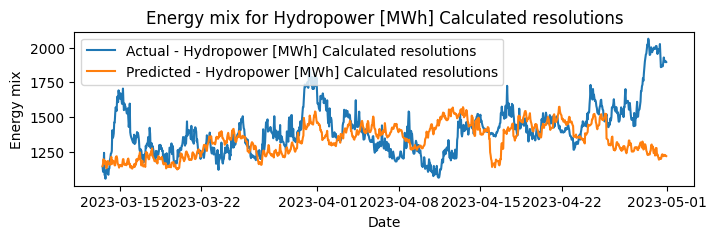

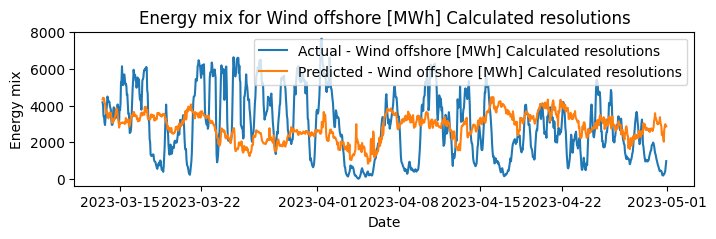

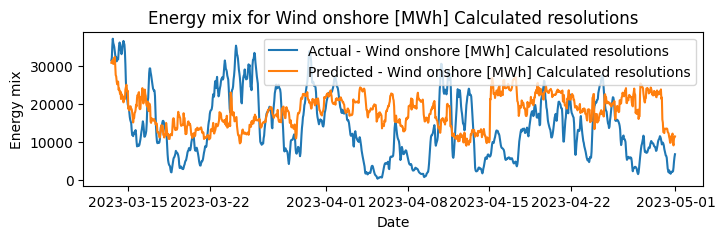

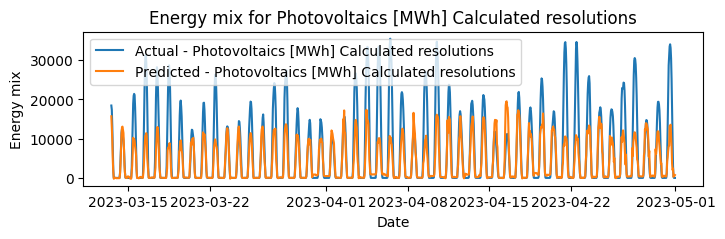

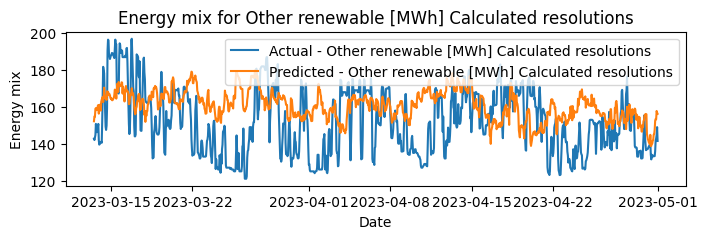

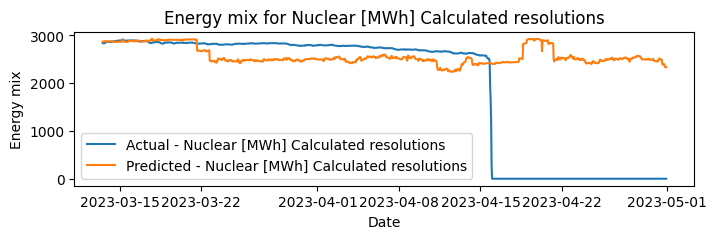

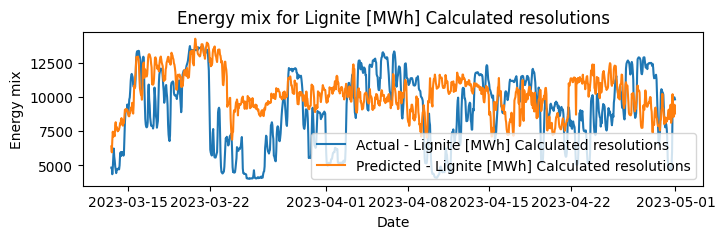

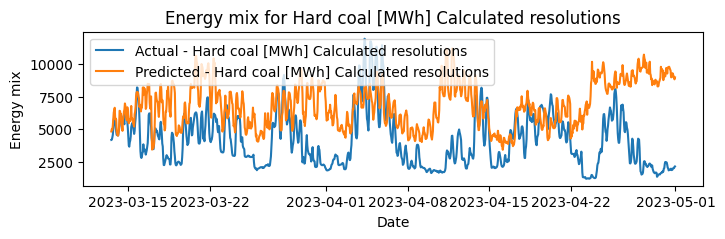

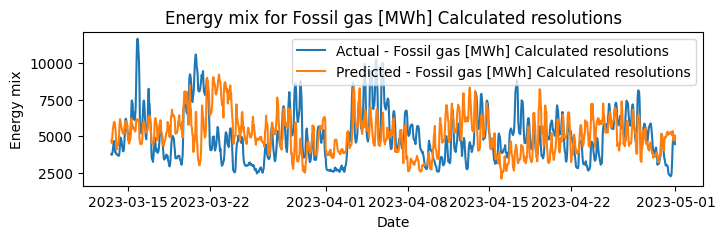

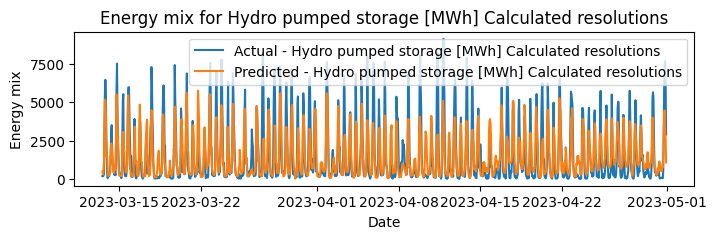

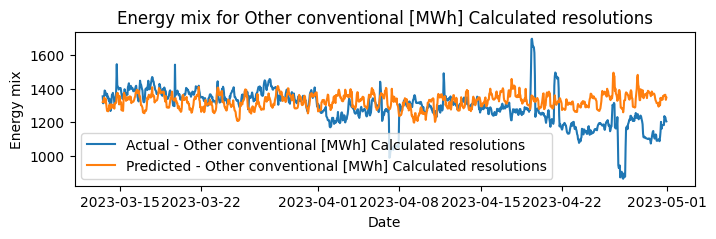

In [ ]:
# Plot the predictions vs the actual values
import matplotlib.pyplot as plt

for i, col in enumerate(value_cols):

       fig, ax = plt.subplots(figsize=(8, 2))
       ax.plot(y_validation.index, y_validation[col], label='Actual - ' + col)
       ax.plot(y_validation.index, y_pred[:, i], label='Predicted - ' + col)

       ax.set(xlabel="Date",
              ylabel="Energy mix",
              title=f"Energy mix for {col}")       
       ax.legend()
       plt.show()